# Exercise 4 - Python: Neural Networks Learning

## *Part One*: Neural Networks

Recognizing handwritten digits.  Though the source is not explicitly mentioned, it is just like the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database).

Each value of $X$ will be a 20x20 grid of values representing the grayscale intensity at that location "unrolled" into a 400-dimensional vector.  Here is an example for the first number in our data, $X^{(1)}$:

$\hspace{1cm} X^{(1)} = \begin{bmatrix}x_{(1, 1)}^{(1)},\ x_{(1, 2)}^{(1)},\ \dots\ x_{(1, 20)}^{(1)} \\
                                    x_{(2, 1)}^{(1)},\ x_{(2, 2)}^{(1)},\ \dots\ x_{(2, 20)}^{(1)} \\
                                    \vdots \\ 
                                    x_{(20, 1)}^{(1)},\ x_{(20, 2)}^{(1)},\ \dots\ x_{(20, 20)}^{(1)} \\ 
                    \end{bmatrix}
\rightarrow \begin{bmatrix} x_1^{(1)},\ x_2^{(1)},\ \dots\ x_{400}^{(1)} \end{bmatrix}
\rightarrow (x^{(1)})^T$

Here is our collection of all of the numbers for $X$:

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(400)})^T \end{bmatrix}$

---

Beginning with package imports, data loading, and initial visualization

In [1]:
import numpy as np
import pandas as pd
from math import floor, ceil  # Used in calculating subplot parameters
from scipy.optimize import minimize  # Discovering optimal parameters
from sklearn.preprocessing import OneHotEncoder  # Feature transformation
import matplotlib.pyplot as plt

# For comparing answers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import scipy.io as sio  # Used to load the Octave/MATLAB *.mat files

plt.style.use('ggplot')

%matplotlib inline

Note: y has 0 listed as 10, but we will be leaving this alone until our final predictions since the thetas we are provided for the first part of the exercise are structured for this.  In other words, it would be more trouble than it's worth to reshape our provided thetas.

In [2]:
# Loading in the data from the .mat files
data = sio.loadmat('ex4/ex4data1.mat')
X, y = data['X'], data['y']

# Flattening y from an array of arrays into one vector
y = y.flatten()

# Importing weights provided by the exercise
weights = sio.loadmat('ex4/ex4weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']

print(X.shape)
X

(5000, 400)


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

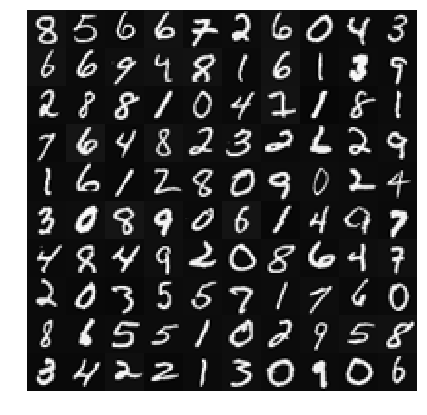

In [3]:
# Randomly sampling 100 numbers to display
# 1: excludes the intercept
random100 = X[np.random.randint(X.shape[0], size=100), :]


def plot_digits(digits, width=8, height=8):
    """Plots a grid of the supplied digits"""
    # Creating the overall figure to fill with plots of the numbers
    fig = plt.figure(figsize=(width, height))

    # Calculates the number of columns/rows for the subplot grid
    figShape = np.sqrt(digits.shape[0])

    # Loop over numbers to plot into the overall figure
    for i, number in enumerate(digits):  # Enumerating to include index
        number = number.reshape(20, 20).T  # Reshape X into 20x20 array
        ax = fig.add_subplot(floor(figShape),  # Rows
                             ceil(figShape),  # Columns
                             i + 1)  # Positioning
        plt.imshow(number, cmap='gray')  # Plotting the number

        # Removing unnecessary components for aesthetics
        plt.grid(False)
        plt.axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()


plot_digits(digits=random100, width=7, height=7)

### Feedforward and Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \big[-y_k^{(i)}log((h_\theta(x^{(i)}))_k) - (1-y_k^{(i)}) log(1-(h_\theta(x^{(i)}))_k) \big] + \frac{\lambda}{2m} \big[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j, k}^{(1)})^2 +
\sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j, k}^{(2)})^2 \big]$

Note: $h_\theta(x^{(i)})_k = a^{(3)}_k$, or the activation of the $k$-th output unit

#### Regularization Parameter

$\frac{\lambda}{2m} \big[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j, k}^{(1)})^2 +
\sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j, k}^{(2)})^2 \big]$

Note: The regularization parameter ignores the bias units

The exercise states that the unregularized cost function should be around $0.287629$, and the regularized cost function with $\lambda = 1$ should be around $0.383770$

In [4]:
def sigmoid(z):
    """
    Calculates the sigmoid function for use as 
    the activation function in the neural network
    """
    z = 1 / (1 + np.exp(-z))
    return z

def forward_propagate(thetas, X):
    """
    Forward propagates a sequential neural network with the provided input
    Assumes X does not contain the bias term
    
    Returns the following:
    0: Numerical predictions
    1: Class probabilities
    2: Values of the nodes pre-activation (excluding input layer)
    3: Values of the nodes post-activation (exluding input layer)
    """
    h = X.copy()
    
    # Lists to store items 2 and 3 in
    nodes = []
    activations = []
    activations.append(np.insert(h, 0, 1, axis=1))
    
    # Forward propagation
    for theta in thetas:
        h = np.insert(h, 0, 1, axis=1)  # Adding the bias term
        h = h.dot(theta.T)  # Multiplying by the weights
        nodes.append(h)
        h = sigmoid(h)  # Activation function
        activations.append(np.insert(h, 0, 1, axis=1))
        
    # Moves the class probabilities for digit 0 to the 0th index
    classProbabilities = np.roll(h, 1)
    
    # Returns index with the highest value
    prediction = np.argmax(classProbabilities, axis=1)

    return prediction, h, nodes, activations


def nn_cost(thetas, X, y, C=0.0):
    """
    Returns the cost for a sequential neural network using the 
    forward_propagate function
    """
    m = y.size
    
    # Generating class probabilities
    h = forward_propagate(thetas, X)[1]
    
    # One hot encoding y into binary arrays for the cost function
    y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()

    # Calculating the regularized cost
    error = np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h))

    # Removing bias terms from regularization through np.delete()
    regParameter = [np.sum(np.delete(theta, 0, axis=1)**2) for theta in thetas]
    regParameter = (C / (2 * m)) * sum(regParameter)

    cost = (1 / m) * error + regParameter
    return cost

print('Unregularized cost:',
      nn_cost([theta1, theta2], X, y))
print('Regularized cost:',
      nn_cost([theta1, theta2], X, y, C=1.0))

Unregularized cost: 0.287629165161
Regularized cost: 0.383769859091


---

##  **Part 2:** Backpropagation

Here we'll learn parameters for our neural network through backpropagation.  We have to first create two helper functions in order to conduct backpropagation:

1. **restructure_theta:** The optimization function won't work with matrices, so we have to flatten our thetas into one long vector.  This function will allow us to reshape the vector back into the original matrices for theta in order to use it with the **forward_propagate** function.
2. **sigmoid_gradient:** The partial derivative of the sigmoid function which will be used to help calculate the gradient in backpropagation

After that, we will have to create new values for our initial $\Theta^{(l)}$.  We can't use $0$s like we did in the previous exercises because this more or less causes our nodes to drop out.

We'll then finally build the backpropogation function, but before we optimize it, we have to do something called gradient checking to ensure that our backpropagation is working as expected.  If it is, we'll proceed with optimizing our $\Theta^{(l)}$ and generate predictions.

In [5]:
# Creating global variables to be used in reshaping and function parameters
input_layer_size = X.shape[1]  # 400
hidden_layer_size = theta2[0].shape[0] - 1  # 25 - excluding bias unit
output_layer_size = len(np.unique(y))  # 10

# Creating one long theta to plug into functions
long_theta = np.concatenate((theta1.flatten(), theta2.flatten()))


def restructure_theta(long_theta, thetas):
    """
    Reshapes the long array of thetas into matrices for each theta
    """
    reshaped_thetas = []
    indices = 0
    for i, theta in enumerate(thetas):
        if i == 0:
            reshaped = np.reshape(
                long_theta[:thetas[i].size], thetas[i].shape)
            reshaped_thetas.append(reshaped)
            indices += reshaped.size
        else:
            reshaped = np.reshape(
                long_theta[indices:indices + thetas[i].size], thetas[i].shape)
            reshaped_thetas.append(reshaped)
            indices += reshaped.size

    return reshaped_thetas


print('Original theta 2 shape:', theta2.shape)
print('Reshaped theta 2 shape:', restructure_theta(
    long_theta, [theta1, theta2])[1].shape)

Original theta 2 shape: (10, 26)
Reshaped theta 2 shape: (10, 26)


### Sigmoid Gradient

$g'(z) = \frac{d}{dz}g(z) = g(z)(1-g(z))$

where

$sigmoid(z)=g(z)=\frac{1}{1+e^{-z}}$

In [6]:
def sigmoid_gradient(z):
    """Returns the gradient of a sigmoid function"""
    gradient = np.multiply(sigmoid(z), (1 - sigmoid(z)))
    return gradient

sigmoid_gradient(0)

0.25

### Random Initialization

Randomly selecting values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$ since initial $\Theta^{(l)}$ values of $0$ will more or less cancel out the neurons they are assigned to

We will use the recommended approach for selecting $\epsilon$ by using the number of units in the network:

$\epsilon_{init} =  \frac{\sqrt(6)}{\sqrt{L_{in}+L_{out}}}$

where

$L_{in} = s_l$ and $L_{out} = s_{l+1}$, or the number of nodes in the input and output layers (excluding the bias nodes)

In [7]:
# Num nodes in the input and output layers excl. bias nodes
epsilon = np.sqrt(6) / np.sqrt(400 + 10)

initialThetas = np.random.uniform(-epsilon, epsilon,
                                  size=theta1.size + theta2.size)

initialThetas.size

10285

### Backpropagation

<img src="https://sebastianraschka.com/images/faq/visual-backpropagation/backpropagation.png">

As a reminder, backpropagation is a way to learn parameters for neural networks.  On a high level, we first propagate forward with initial parameters (which we created above by uniformly selecting between $[-\epsilon_{init}, \epsilon_{init}]$), then we obtain the error for our output nodes, and use that to do weighted averages moving backwards through the network to find which nodes in the hidden layer contributed to the error.  We can then calculate the gradient which tells us how we can adjust the parameters to decrease the error.  Finally, we pair it with an optimization algorithm in order to perform several iterations.

Vectorized implementations of backpropagation exist, but Professor Ng stressed using a for loop that iterates through each training example for the sake of simplicity.  Here is the mechanical approach for performing gradient descent:

$\hspace{0.5cm}$ **Note:** These formulas are specific to our neural network with one hidden layer

1. Set the input layer's values $(a^{(1)})$ to the $t$-th training example $x^{(t)}$.  Perform a feedforward pass to compute the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3.  Remember to add the $+1$ term to ensure the vectors of activation for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit.

2. For each output unit $k$ in layer 3 (the output layer), set $$\delta_k^{(3)} = (a_k^{(3)} - y_k)$$ where $y_k \in \{0,1\}$ indicates whether the current training example belongs to class $k (y_k = 1)$, or if it belongs to a different class $(y_k = 0)$.  This is an "error term" that measures how much that node was "responsible" for any errors in the output.

3. For the hidden layer $l=2$, set $$\delta^{(2)} = (\theta^{(2)})^T \delta^{(3)}.*g'(z^{(2)})$$ This is the part that propagates backward, and like step 2, it is an "error" term that measures how much that node was "responsible" for any errors in the output.  However, we determine this by a weighted average of the error terms in the output layer $(l+1)$.

4. Accumulate the gradient from this training example using the following formula.  Note that you should skip or remove $\delta_0^{(2)}$ $$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^T$$

5. Obtain the (unregularized) gradient for the neural network cost function by multiplying the accumulated gradients by $\frac{1}{m}$: $$\frac{\partial}{\partial \theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}$$

5. Obtain the regularized gradient for the neural network cost function by multiplying the accumulated gradients by $\frac{1}{m}$ and applying the regularization term: $$\frac{\partial}{\partial \theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \begin{cases}\frac{1}{m}\Delta_{ij}^{(l)} & for\ j=0 \\ \frac{1}{m}\Delta_{ij}^{(l)} + \frac{\lambda}{m}\Theta_{ij}^{(l)} & for\ j\geq 1 \end{cases}$$

Using the obtained gradient, we can adjust the values of $\Theta^{(l)}$ and do it all over again.

In [8]:
def backpropagate(long_theta, thetas, X, y, C=0.0):
    """
    Calculates the gradients for provided thetas through 
    long_thetas is the vector of all thetas, and is the first parameter
    since this is what the optimization changes

    Also calculates the cost using nn_cost()
    """
    m = y.size

    # Reshaping long_theta into original form for forward_propagate()
    reshaped_thetas = restructure_theta(long_theta, thetas)

    # Gathering info from forward propagation
    # h is class probabilities with 0 indexed at the end
    _, h, nodes, activations = forward_propagate(reshaped_thetas, X)

    cost = nn_cost(reshaped_thetas, X, y, C)

    # Backpropagation
    # One hot encoding y into binary arrays
    y = OneHotEncoder().fit_transform(y.reshape(-1, 1)).toarray()
    
    # Creating initial deltas of 0 to be filled
    delta1 = np.zeros(reshaped_thetas[0].shape)
    delta2 = np.zeros(reshaped_thetas[1].shape)

    # Looping through each individual digit in the training set
    for digit in range(m):
        # Step 1: Grabbing appropriate items for the backpropagation calculation
        # Using matrix() to quickly reshape for linear algebra
        input_nodes = np.matrix(activations[0][digit])
        hidden_nodes = np.matrix(nodes[0][digit])
        hidden_activation = np.matrix(activations[1][digit])
        output_nodes = h[digit]
        actual = y[digit]

        # Step 2: Calculating delta 3 - the "error term" assigning responsibility
        # of errors to nodes in the output layer
        d3 = np.matrix(output_nodes - actual)
        hidden_nodes = np.insert(hidden_nodes, 0, 1)  # Adding the bias term

        # Step 3: Calculating delta 2 - the weighted average of error terms in
        # the output layer to assign responsibility to nodes in the hidden layer
        d2 = np.multiply((reshaped_thetas[1].T * d3.T).T,
                         sigmoid_gradient(hidden_nodes))

        # Step 4: Accumulating the gradients
        delta1 = delta1 + (d2[:, 1:]).T * input_nodes
        delta2 = delta2 + d3.T * hidden_activation

    # Step 5: Obtaining the gradient for the cost function
    delta1 = (1 / m) * delta1
    delta2 = (1 / m) * delta2

    # Adding the regularization terms
    delta1[:, 1:] = delta1[:, 1:] + (reshaped_thetas[0][:, 1:] * C) / m
    delta2[:, 1:] = delta2[:, 1:] + (reshaped_thetas[1][:, 1:] * C) / m

    # Combining the gradients into one long gradient for the 
    # optimization function
    gradient = np.concatenate((np.ravel(delta1), np.ravel(delta2)))

    return cost, gradient


backpropagate(initialThetas, [theta1, theta2], X, y, 1.0)

(7.2327315479954875,
 array([ -8.95145698e-03,  -1.94730824e-06,  -7.65684633e-06, ...,
          1.92389766e-01,   2.29259867e-01,   1.87425220e-01]))

### Optimizing $\Theta^{(l)}$ and Predictions

In [9]:
# Takes ~5.5 minutes
results = minimize(fun=backpropagate, x0=initialThetas,
                   args=([theta1, theta2], X, y, 1.0),
                   method='TNC', jac=True,
                   options={'maxiter': 250})

results

     fun: 0.33420686759533424
     jac: array([  1.80228134e-04,   1.68170235e-07,   6.70234684e-07, ...,
         2.31815535e-05,   1.34060516e-05,   1.28535893e-04])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 19
  status: 3
 success: False
       x: array([  4.70153482e-01,   8.40851174e-04,   3.35117342e-03, ...,
         9.02116508e-01,  -1.95948715e+00,   1.56318992e+00])

In [10]:
initial1, initial2 = restructure_theta(initialThetas, [theta1, theta2])
newTheta1, newTheta2 = restructure_theta(results['x'], [theta1, theta2])

print('Initial cost:', nn_cost([initial1, initial2], X, y))
print('Optimized theta cost:', nn_cost([newTheta1, newTheta2], X, y))

Initial cost: 7.22771385928
Optimized theta cost: 0.141417532217


In [11]:
predictions = forward_propagate([newTheta1, newTheta2], X)[0]

results = pd.DataFrame({'Prediction': predictions,
                        'Actual': np.where(y == 10, 0, y)})

results['Correct'] = np.where(results['Actual'] == results['Prediction'],
                              1, 0)

print('Our Accuracy: {0}%'.format(results['Correct'].mean() * 100))

Our Accuracy: 99.46000000000001%


---

##  **Part 3:** Visualizing the hidden layer

Here we will visualize the representations captured by the hidden layer.  This is done by reshaping the hidden layer $\Theta$ into a 20x20 matrix and plotting it.  This will give us an idea of the patterns our network is learning.  It's a similar idea of [eigenfaces](https://en.wikipedia.org/wiki/Eigenface) (even though the math behind them is different), and it is really cool!

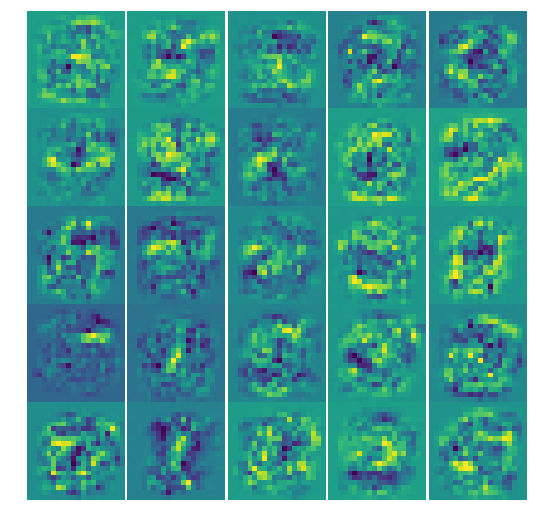

In [12]:
def plot_hidden_layer(theta, width=8, height=8):
    """
    Visualizes the hidden layer by plotting the values of theta applied
    to the input layer.  Darker sections correspond to heavier weights.
    """
    # Creating the overall figure to fill with plots of the hidden layer
    fig = plt.figure(figsize=(width, height))

    # Calculates the number of columns/rows for the subplot grid
    figShape = np.sqrt(theta.shape[0])

    # Loop over thetas to plot into the overall figure
    for i, node in enumerate(theta):  # Enumerating to include index
        node = node.reshape(20, 20).T  # Reshape theta into 20x20 array
        ax = fig.add_subplot(floor(figShape),  # Rows
                             ceil(figShape),  # Columns
                             i + 1)  # Positioning
        plt.imshow(node)  # Plotting the theta

        # Removing unnecessary components for aesthetics
        plt.grid(False)
        plt.axis('off')
        fig.subplots_adjust(wspace=0, hspace=0)

    plt.show()


plot_hidden_layer(theta=newTheta1[:, 1:], width=9, height=9)